## Pandas to read the csv and numpy for mathematical calculations

In [1]:
import pandas as pd
import geopandas

import numpy as np

## Reading the data and breaking it into 3 categories for Troops, Cities and Temperature

In [2]:
data = pd.read_csv('minard-data.csv')

### Cities data
cities = data[["LONC", "LATC", "CITY"]].copy()
cities = cities.dropna()
cities.columns = ['Longitude', 'Latitude', 'City']

### Temperature
temperatures = data[["LONT", "TEMP", "DAYS", "MON", "DAY"]].copy()
temperatures = temperatures[temperatures['TEMP'].notna()]

### Troops
troops = data[["LONP", "LATP", "SURV" , "DIR", "DIV"]].copy()
troops = troops.dropna()
troops_attack = troops[troops.DIR=='A']
troops_retreat = troops[troops.DIR=='R']

### Loading cities from longitude and latitudes

In [3]:
gdf = geopandas.GeoDataFrame(cities[['City', 'Latitude', 'Longitude']], geometry=geopandas.points_from_xy(cities.Longitude, cities.Latitude))

print(gdf.head())

        City  Latitude  Longitude                   geometry
0      Kowno      55.0       24.0  POINT (24.00000 55.00000)
1      Wilna      54.7       25.3  POINT (25.30000 54.70000)
2   Smorgoni      54.4       26.4  POINT (26.40000 54.40000)
3  Molodexno      54.3       26.8  POINT (26.80000 54.30000)
4  Gloubokoe      55.2       27.7  POINT (27.70000 55.20000)


C:\Users\amita\anaconda3\envs\data_viz\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


### Loading Matplotlib methods and functions that we are going to use

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.collections import LineCollection
from matplotlib.patches import ConnectionPatch

from matplotlib import font_manager

font_path = 'BentonSans Book.otf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

## Let's find point of intersection of temperature lines and the troops retreat lines

In [5]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

intersection_points = []
for vals in temperatures.iterrows():
    long = vals[1]['LONT']
    temp = vals[1]['TEMP']
    
    min_ind = np.argmin(np.abs(troops_retreat['LONP'].values-long))
    
    if min_ind==0:
        min_ind2 = 1
        
    elif long>troops_retreat['LONP'].values[min_ind]:
        min_ind2 = min_ind-1
    
    else:
        min_ind2 = min_ind+1
    
    ## Points on troop retreat segment
    pointA = troops_retreat.iloc[min_ind,0:2].values
    pointB = troops_retreat.iloc[min_ind2,0:2].values
    
    #Points on temperature line
    pointC = (long, temp)
    pointD = (long, temp+100)
    intersection_points.append(line_intersection((pointA, pointB), (pointC, pointD)))

## Final plot

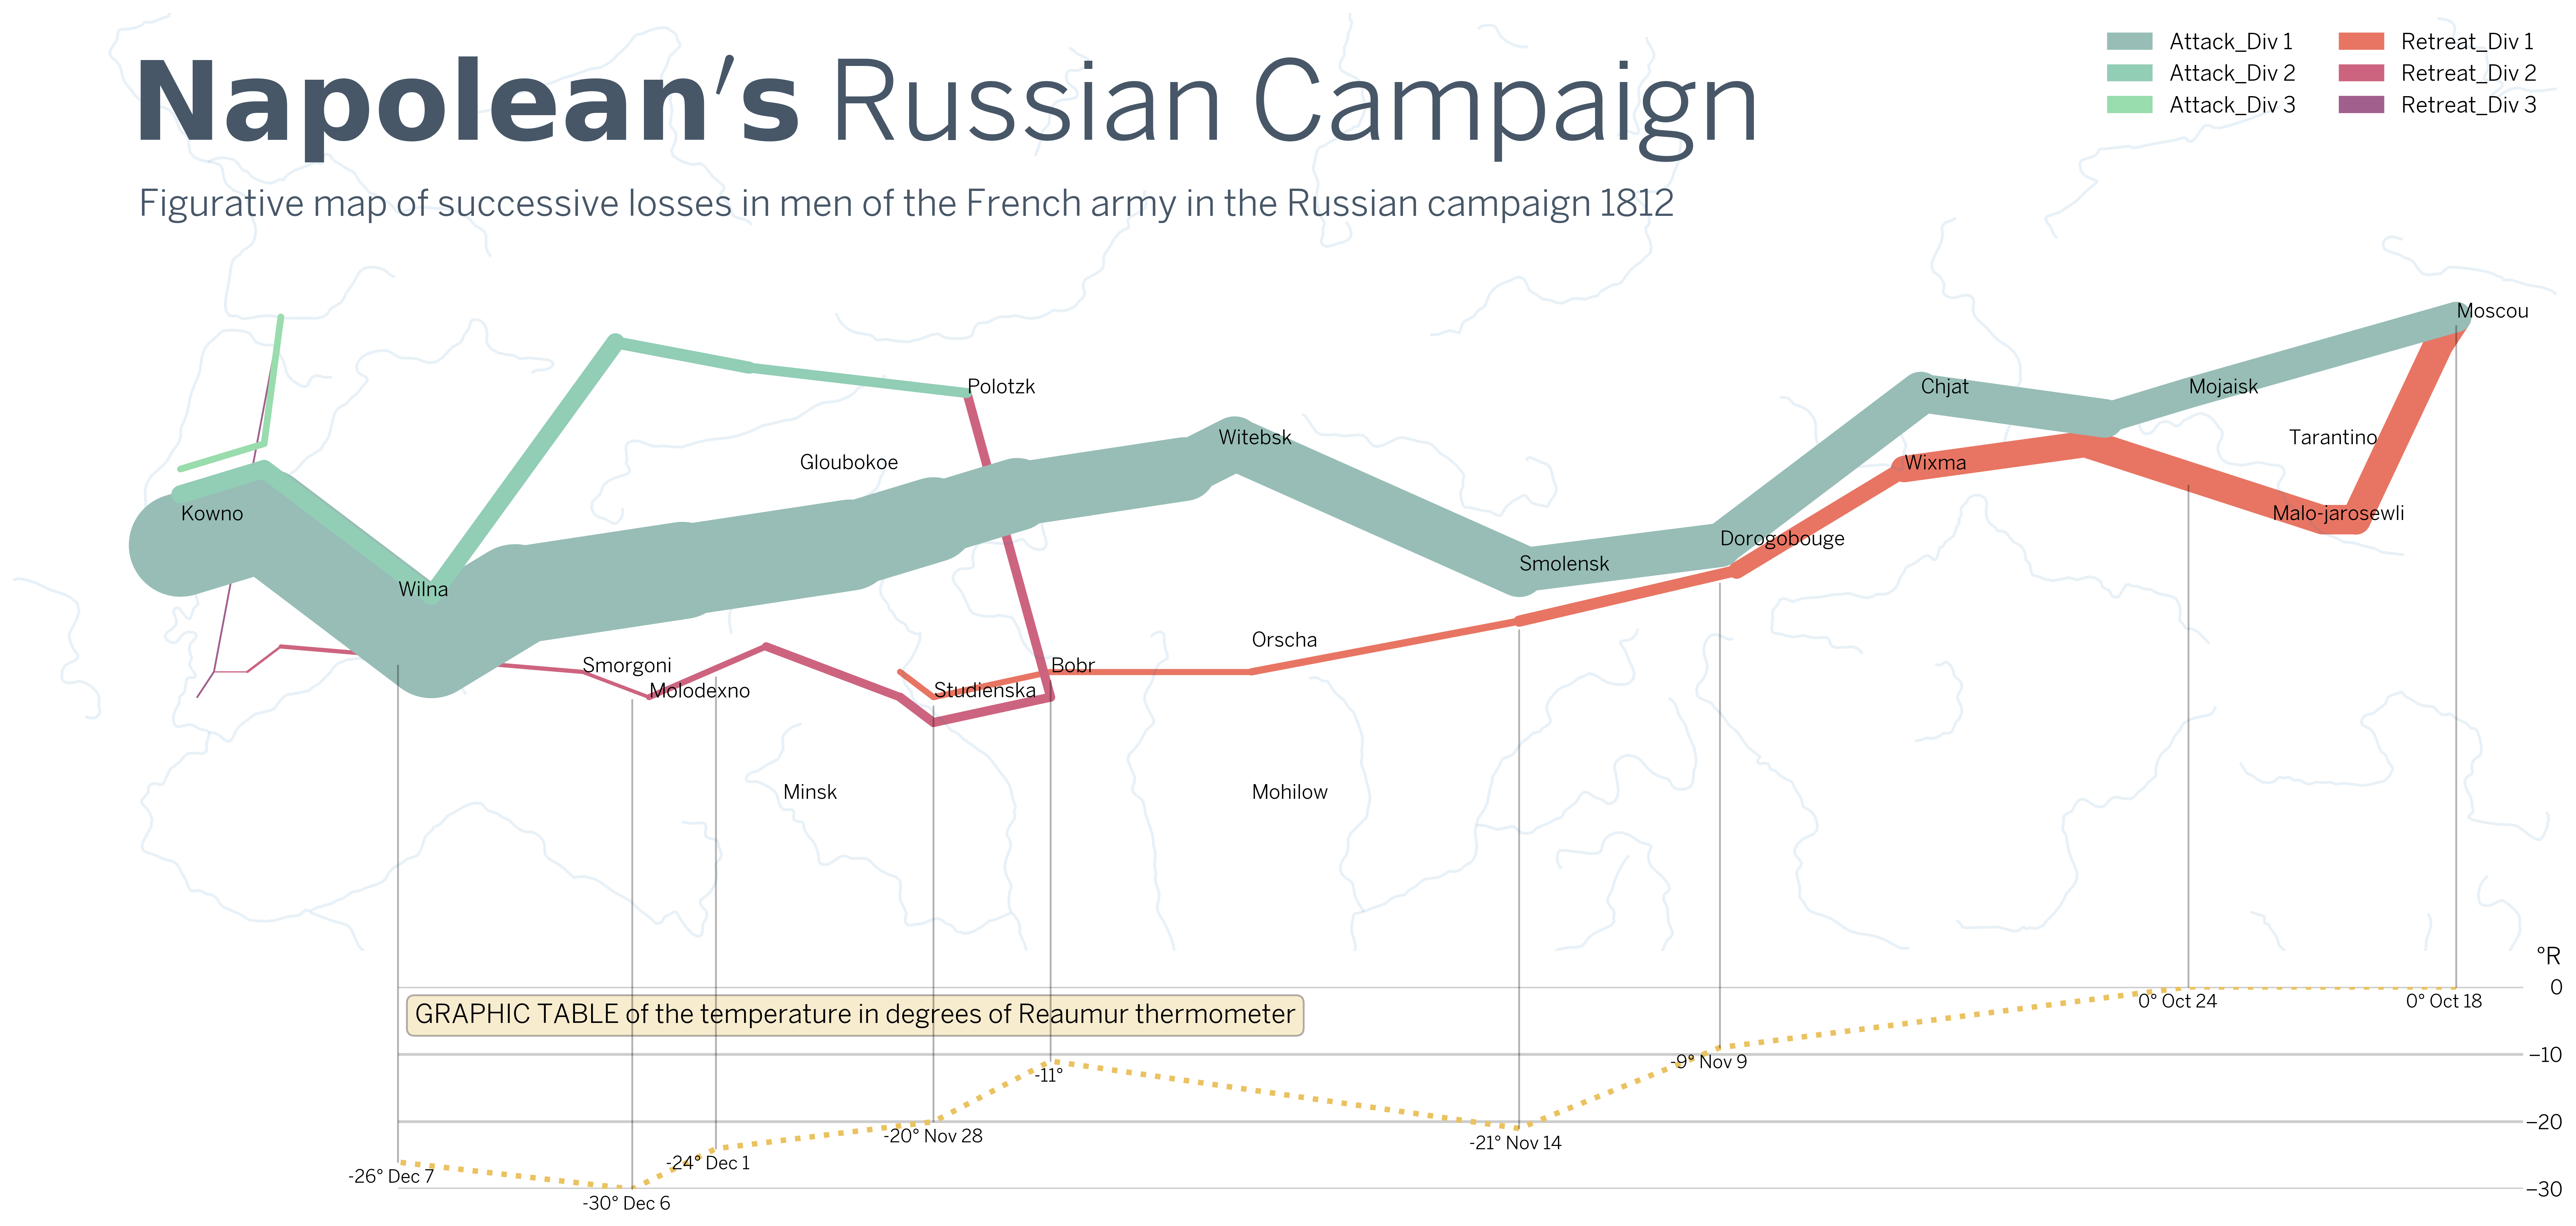

In [14]:
import matplotlib.patches as mpatches

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(25,12), dpi=400, gridspec_kw={'height_ratios': [5, 1]})

rivers = geopandas.read_file("rivers_europe.geojson")
rivers.plot(ax=ax1, alpha=0.1)

attack_colours = ['#97BDB6','#92CDB6','#99DCAD']
retreat_colours = ['#E87563','#CD647F','#A15F8E']

for div in (1,2,3):
    attack_data = troops_attack[troops_attack.DIV==div]
    retreat_data = troops_retreat[troops_retreat.DIV==div]    
    attack_data = pd.concat([attack_data, retreat_data.iloc[0:1,:]])
    
    #For attack info
    lwidths = attack_data.SURV/6000
    points = np.array([attack_data.LONP, attack_data.LATP]).T.reshape(-1, 1, 2)
    attack_segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(attack_segments, linewidth= lwidths, color=attack_colours[div-1], capstyle='round', zorder=2, label=f"Div_Attack {div}")
    ax1.add_collection(lc)

    #For retreating info
    lwidths = retreat_data.SURV/6000
    points = np.array([retreat_data.LONP, retreat_data.LATP]).T.reshape(-1, 1, 2)
    retreat_segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(retreat_segments, linewidth= lwidths, color=retreat_colours[div-1], capstyle='round', zorder=1, label=f"Div_Retreat {div}")
    ax1.add_collection(lc)
    
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.City):
    ax1.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points", zorder=3, fontsize=11, weight='bold')

ax1.set_xlim(23,38.2)
ax1.set_ylim(53.3,57)
ax1.axis('off')

ax1.annotate(r"$\bf{Napolean's }$"+" Russian Campaign", (23.7, 56.5),
             color='#475768', fontsize=60)
ax1.annotate("Figurative map of successive losses in men of the French army in the Russian campaign 1812",
             (23.75, 56.2), color='#475768', fontsize=20, weight='bold')


#Let's draw temperature data
#X............................................................................X
for i, vals in enumerate(temperatures.iterrows()):
    xy_temp = tuple(vals[1][['LONT', 'TEMP']].values)
    xy_retreat = intersection_points[i]
    con = ConnectionPatch(xyA=xy_temp, coordsA=ax2.transData,
                          xyB=xy_retreat, coordsB=ax1.transData,
                          arrowstyle="-", shrinkB=5, alpha=0.3)
    fig.add_artist(con)
    
    long, temp, mon, day = vals[1][['LONT','TEMP', 'MON', 'DAY']].values
    if pd.isna(mon):
        lab = f"{int(temp)}°"
        loc = (long-0.1,temp-3)
    else:
        lab = f"{int(temp)}° {mon} {int(day)}"
        loc = (long-0.3,temp-3)
        
    ax2.annotate(lab, (long, temp), xytext=loc)
    
for val in (0, -10, -20, -30):
    ax2.hlines(val, long, 38, alpha=0.2, color='black')

ax2.set_xlim(23,38.2)
ax2.set_ylim(-30,0)
ax2.yaxis.tick_right()
for tick in ax2.yaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")

ax2.yaxis.set_label_position("right")
ax2.set_ylabel("°R", rotation=0, fontsize=13)
ax2.yaxis.set_tick_params(labelsize=11)
ax2.yaxis.set_label_coords(0.997, 1.2)
ax2.set_xticks([])
ax2.annotate("GRAPHIC TABLE of the temperature in degrees of Reaumur thermometer", (25.4, -5.3),
             bbox= dict(facecolor='#EAC260', alpha=0.3, boxstyle='round'), color='black', 
             size='x-large', weight='bold')

ax2.plot(temperatures.LONT, temperatures.TEMP, c='#EAC260', lw=3, linestyle=':')
ax2.tick_params(axis='both', which='both',length=0)
#X............................................................................X

#Adding legend
#X............................................................................X
legend_dict = {'Attack_Div 1':attack_colours[0], 'Attack_Div 2':attack_colours[1], 'Attack_Div 3':attack_colours[2],
               'Retreat_Div 1':retreat_colours[0], 'Retreat_Div 2':retreat_colours[1], 'Retreat_Div 3':retreat_colours[2]}

patchList = []
for key in legend_dict:
    data_key = mpatches.Patch(color=legend_dict[key], label=key)
    patchList.append(data_key)

ax1.legend(handles=patchList, ncol=2, loc='best', frameon=False, fontsize=12)
#X............................................................................X

#Fixing spaces between the two subplots
plt.subplots_adjust(wspace=0, hspace=0)
plt.box(False)
plt.show()